# HW3: RNNs and Sequences

This assignment is due Sunday, March 12 at 11:59pm Central Time.

This assignment can be completed in **groups of two**. If you need to find a partner, please post in the pinned note on Piazza.

Once you have formed your groups, the work you submit must belong only to your group members. Do not submit another team's work as your own, and do not allow another team to submit your work as their own. If you use resources you find online, you must cite those in your notebook.

To submit this assignment, you should commit to your GitHub account:

* your Net ID(s) in the netid file; one per line. Please do not put your name in your notebook; we will grade these anonymously.

* a hw3.pdf printout of the completed notebook that shows all your answers.

* your final hw3.ipynb notebook with outputs saved. If we run your notebook from scratch, it should produce an output identical to your PDF. You can edit your notebook however you want (on Colab, on your local machine, somewhere else); just upload the latest version of it to GitHub.

Your GitHub account must submit contain all three of these, or you will lose points. We will not accept late work except in extreme settings.

__Finally, each question specifies exactly what should be provided in your answer -- for example, if no code is requested, do not provide it. Your submitted notebook (and PDF) should not contain any additional content or cells beyond what is requested.__

In [ ]:
# If using local runtime
# base_dir = "~/Documents"
# If using hosted runtime
base_dir = "/content"

# helper code from the course repository
!cd $base_dir && git clone -q https://github.com/zachwooddoughty/cs449w23.git
# install common pacakges used for deep learning
!cd $base_dir/cs449w23/ && pip install -q -r requirements.txt &> logs.txt

# Using huggingface datasets and tokenizers
!pip install -q datasets transformers

# make sure we're in the right directory
%cd $base_dir/cs449w23/
!git pull -q origin main

fatal: destination path 'cs449w23' already exists and is not an empty directory.
/content/cs449w23


In [ ]:
%matplotlib inline

import datetime
import math
import torch
import time
import random
import matplotlib.pyplot as plt
import numpy as np
import IPython.display as ipd
from matplotlib.animation import FuncAnimation
from pathlib import Path
from torch.utils.tensorboard import SummaryWriter
from torchsummary import summary
from tqdm import tqdm
import torchvision
import IPython

from datasets import load_dataset
from transformers import AutoTokenizer, BertTokenizer

from utils.gan import *

----
## <a name="1">Question 1: A Simple Sequence Task (6 points total)</a>

In this question, we'll explore the differences between standard recurrent neural networks (RNNs) and long short-term memory networks (LSTMs) using a simple addition task akin to the one used in the [original LSTM paper](https://www.researchgate.net/publication/13853244_Long_Short-term_Memory).



### __1.1__ Theoretical Comparison (1 point)

__Explain the argument for why we would expect an LSTM to outperform a standard RNN on problems that involve processing long sequences.__

<center>
<strong>LSTM has three gates: input, output and forget gates. They determine what new info to include into the hidden state, what to output from the currecnt hidden state and what to discard repectively. These thress gates tackle the gradient vanishment problem and can still maintain long-term dependencies.</strong>
</center>
<center>


### __1.2__ Empirical Comparison (3 points)

Use the code provided below to compare the performance of a standard RNN to an LSTM on the task defined by the `Add2DigitsDataset`. Do this for three different lengths of sequence (5, 10, and 30). For all experiments, use a hidden size of 128 and 2 layers. Keep your network architecture the same, except for the substitution of the LSTM for an RNN. Provide the following graphs __for each sequence length__:

  1. __Loss as a function of the number of training steps__  
  2. __Training accuracy & validation accuracy as a function of the number of training steps.__

<br/>
<figure>
<center>
<img src="https://github.com/cs449w23/hw3-hw3_449/blob/main/1_2.png"/>
<figcaption>This is the picture 1_2.png in our main branch, the link is fine but it doesn't show picture</figcaption></center>
</figure>
<br/>

<center>
<strong>
You can also see the output box below where we showed the training Loss as a function of the number of training steps.
And the training accuracy & validation accuracy as a function of the number of training steps. 
Both for sequense length 5, 10 and 30.
</strong>
</center>


The following utility code is provided to help with the question. Note that the addition task is formulated as a _classification_ rather than _regression_ problem: because the operands are digits, their sum must be a positive integer in [0, 18], allowing us to output a vector of "class scores" over these potential values.

In [ ]:
def MakeItHot(data, num_tokens):
  """ Make the one hot encoding of the input."""
  i_size, j_size = data.shape
  one_hot_data = torch.zeros(i_size, j_size, num_tokens)
  for i in range(0,i_size):
    for j in range(0,j_size):
      one_hot_data[i,j,data[i,j]] = 1
  return one_hot_data
  
def KeepItCool(data):
  """Just use the data as-is...but with a new dimension added"""
  return torch.unsqueeze(data,2)


class Add2DigitsDataset(torch.utils.data.Dataset):
    """Add2DigitsDataset"""

    def __init__(self, num_examples=3, seq_length=10):
        """Create a set of examples, where each example is a sequence of single 
        positive digits (0 through 9) interspersed with 1 instance of a negative
        one. The game is to sum the final digit in the sequence with the 
        digit after the -1. The correct label y for the sequence x is the sum of 
        these two digits. Here are 3 examples. 

        x = [1, -1, 3, 7, 8, 9]
        y = 12
        
        x = [9, 1, 2, 4, -1, 7, 2, 3, 1, 0]
        y = 7
        
        x = [9, -1, 9, 2 , 1, 3, 0, 5, 6, 4, 7, 8, 5, 1]
        y = 10

        
        PARAMETERS
        ----------
        num_examples    A non-negative integer determining how much data we'll generate
        seq_length      A non-negative integer saying how long the sequences all are.
 
        EXAMPLE USE
        -----------
        dataset = Add2DigitsDataset(num_examples = 100, seq_length = 9)
        data, one_hot_data, labels  = dataset[:]
        print(f'Train instances: one_hot_data (shape {one_hot_data.shape}), labels (shape {labels.shape})')
        loader =  torch.utils.data.DataLoader(dataset, batch_size=10, shuffle=True)
        """

        assert seq_length >= 3, "Seq_length must be a minimum of 3"
        self.seq_length = seq_length
        self.num_tokens = 11

        # make random sequences of integers of the right length
        data = torch.randint(10, (num_examples, seq_length))
        # the labels will go here...
        label = torch.ones(num_examples,1)

        # Now insert our special tokens 
        for x in range(0, num_examples):
          # figure out where to place our special token 
          a_idx = torch.randint(0, seq_length-2, (1,1)).squeeze()
          # insert the special_tokens 
          data[x,[a_idx]] = -1
          # create the label by summing the digit after the special -1 token
          # with the final digit in the sequence
          label[x] = data[x,a_idx+1]+data[x,-1]
        
        # OK. Store data for later.
        self.data = KeepItCool(data)
        self.one_hot_data = MakeItHot(data, num_tokens=self.num_tokens)
        self.label = label.squeeze().long()
        self.lengths = self.seq_length * torch.ones_like(self.label)
        self.lengths = self.lengths.squeeze().long().tolist()

    def __len__(self):
      return len(self.label)

    def __getitem__(self, idx):
      return self.data[idx], self.one_hot_data[idx], self.label[idx] #, self.lengths[idx]


  
# Make sure our dataset looks correct by looking at a few examples...
dataset = Add2DigitsDataset(num_examples=100,seq_length=5)
data, one_hot_data, labels = dataset[:3]
# inputs have shape (B, MAX_L, V) where MAX_L is largest length in batch
print(f'data.shape: {data.shape}, one_hot_data.shape: {one_hot_data.shape}, labels.shape: {labels.shape}')
print(f'data: {data}, one_hot_data: {one_hot_data}, labels: {labels}')

data.shape: torch.Size([3, 5, 1]), one_hot_data.shape: torch.Size([3, 5, 11]), labels.shape: torch.Size([3])
data: tensor([[[ 1],
         [-1],
         [ 5],
         [ 1],
         [ 5]],

        [[ 0],
         [ 3],
         [-1],
         [ 5],
         [ 9]],

        [[ 1],
         [ 4],
         [-1],
         [ 4],
         [ 4]]]), one_hot_data: tensor([[[0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
         [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
         [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]],

        [[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
         [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]],

        [[0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 1., 

In [ ]:
class MyRNN(nn.Module):
  """ A simple RNN that that lets you select architectural features when creating
  a new instance """

  def __init__(self, 
               input_size: int, 
               hidden_size: int, 
               output_size: int,
               num_layers: int = 1,
               use_LSTM: bool = True):

    super().__init__()

    if use_LSTM:  
      self.rnn = nn.LSTM(
        input_size=input_size,
        hidden_size=hidden_size,
        num_layers=num_layers,
        batch_first=True)
    else: 
      self.rnn = nn.RNN(
        input_size=input_size,
        hidden_size=hidden_size,
        num_layers=num_layers,
        batch_first=True)

    self.out_proj = nn.Linear(hidden_size, output_size)
    

  def forward(self, x: torch.Tensor):

    # require batched inputs: (B, MAX_L, V)
    # Here b = the batch size, l = sequence length , v = input token size (i.e. 
    # the number of positiions in a one-hot-encoding array)
    assert x.ndim == 3
    b, l, v = x.shape

    # built-in PyTorch layer handles loop along sequence dimension,
    # including passing hidden state back each time step. It also 
    # handles creating a new initial state for each batch!
    output, hidden = self.rnn(x)

    # for each item in batch, take final output state 
    output = output[:,-1,:]
    
    # apply final linear layer to get predictions
    output = self.out_proj(output)

    return output


# declare the model and try out th untrained model on a sequence
model = MyRNN(
    input_size=11,
    hidden_size= 128,
    output_size=19, # allow outputs in range [0, 18]
    num_layers=2,  
    use_LSTM=False)

# you should use `num_token` = 11: ten tokens for the digits, plus the special -1 token
input =  MakeItHot(torch.tensor([[1,2,3,1,5,6,-1,9,3,4,5,0]]), num_tokens=11)
prediction = model(input)
print(prediction)
print('My prediction is ', torch.argmax(prediction))

tensor([[ 0.0567,  0.1125,  0.0373, -0.0727,  0.0267,  0.0381,  0.0999,  0.0346,
          0.1127,  0.0499,  0.0485, -0.0057,  0.1376,  0.0656, -0.0385, -0.0440,
          0.0470, -0.0229,  0.0188]], grad_fn=<AddmmBackward0>)
My prediction is  tensor(12)


The sequence length is 5
Epoch:   1  in  0.0 min  Loss:        2.9  Train_acc: 0.0135  Test_acc: 0.0988
Epoch:  15  in  0.0 min  Loss:        2.3  Train_acc: 0.2628  Test_acc: 0.1467
Epoch:  30  in  0.0 min  Loss:        1.6  Train_acc: 0.4655  Test_acc: 0.2096
Epoch:  45  in  0.1 min  Loss:        0.8  Train_acc: 0.7853  Test_acc: 0.2754
Epoch:  60  in  0.1 min  Loss:        0.3  Train_acc: 0.9760  Test_acc: 0.3114
Epoch:  75  in  0.1 min  Loss:        0.1  Train_acc: 0.9985  Test_acc: 0.3054
Epoch:  90  in  0.2 min  Loss:        0.0  Train_acc: 1.0000  Test_acc: 0.2934
Epoch: 105  in  0.2 min  Loss:        0.0  Train_acc: 1.0000  Test_acc: 0.3174
Epoch: 120  in  0.2 min  Loss:        0.0  Train_acc: 1.0000  Test_acc: 0.3024
Epoch: 135  in  0.2 min  Loss:        0.0  Train_acc: 1.0000  Test_acc: 0.3084
Epoch: 150  in  0.3 min  Loss:        0.0  Train_acc: 1.0000  Test_acc: 0.3114
Epoch: 165  in  0.3 min  Loss:        0.0  Train_acc: 1.0000  Test_acc: 0.3024
Epoch: 180  in  0.3 min  Lo

Text(0, 0.5, 'Accuracy')

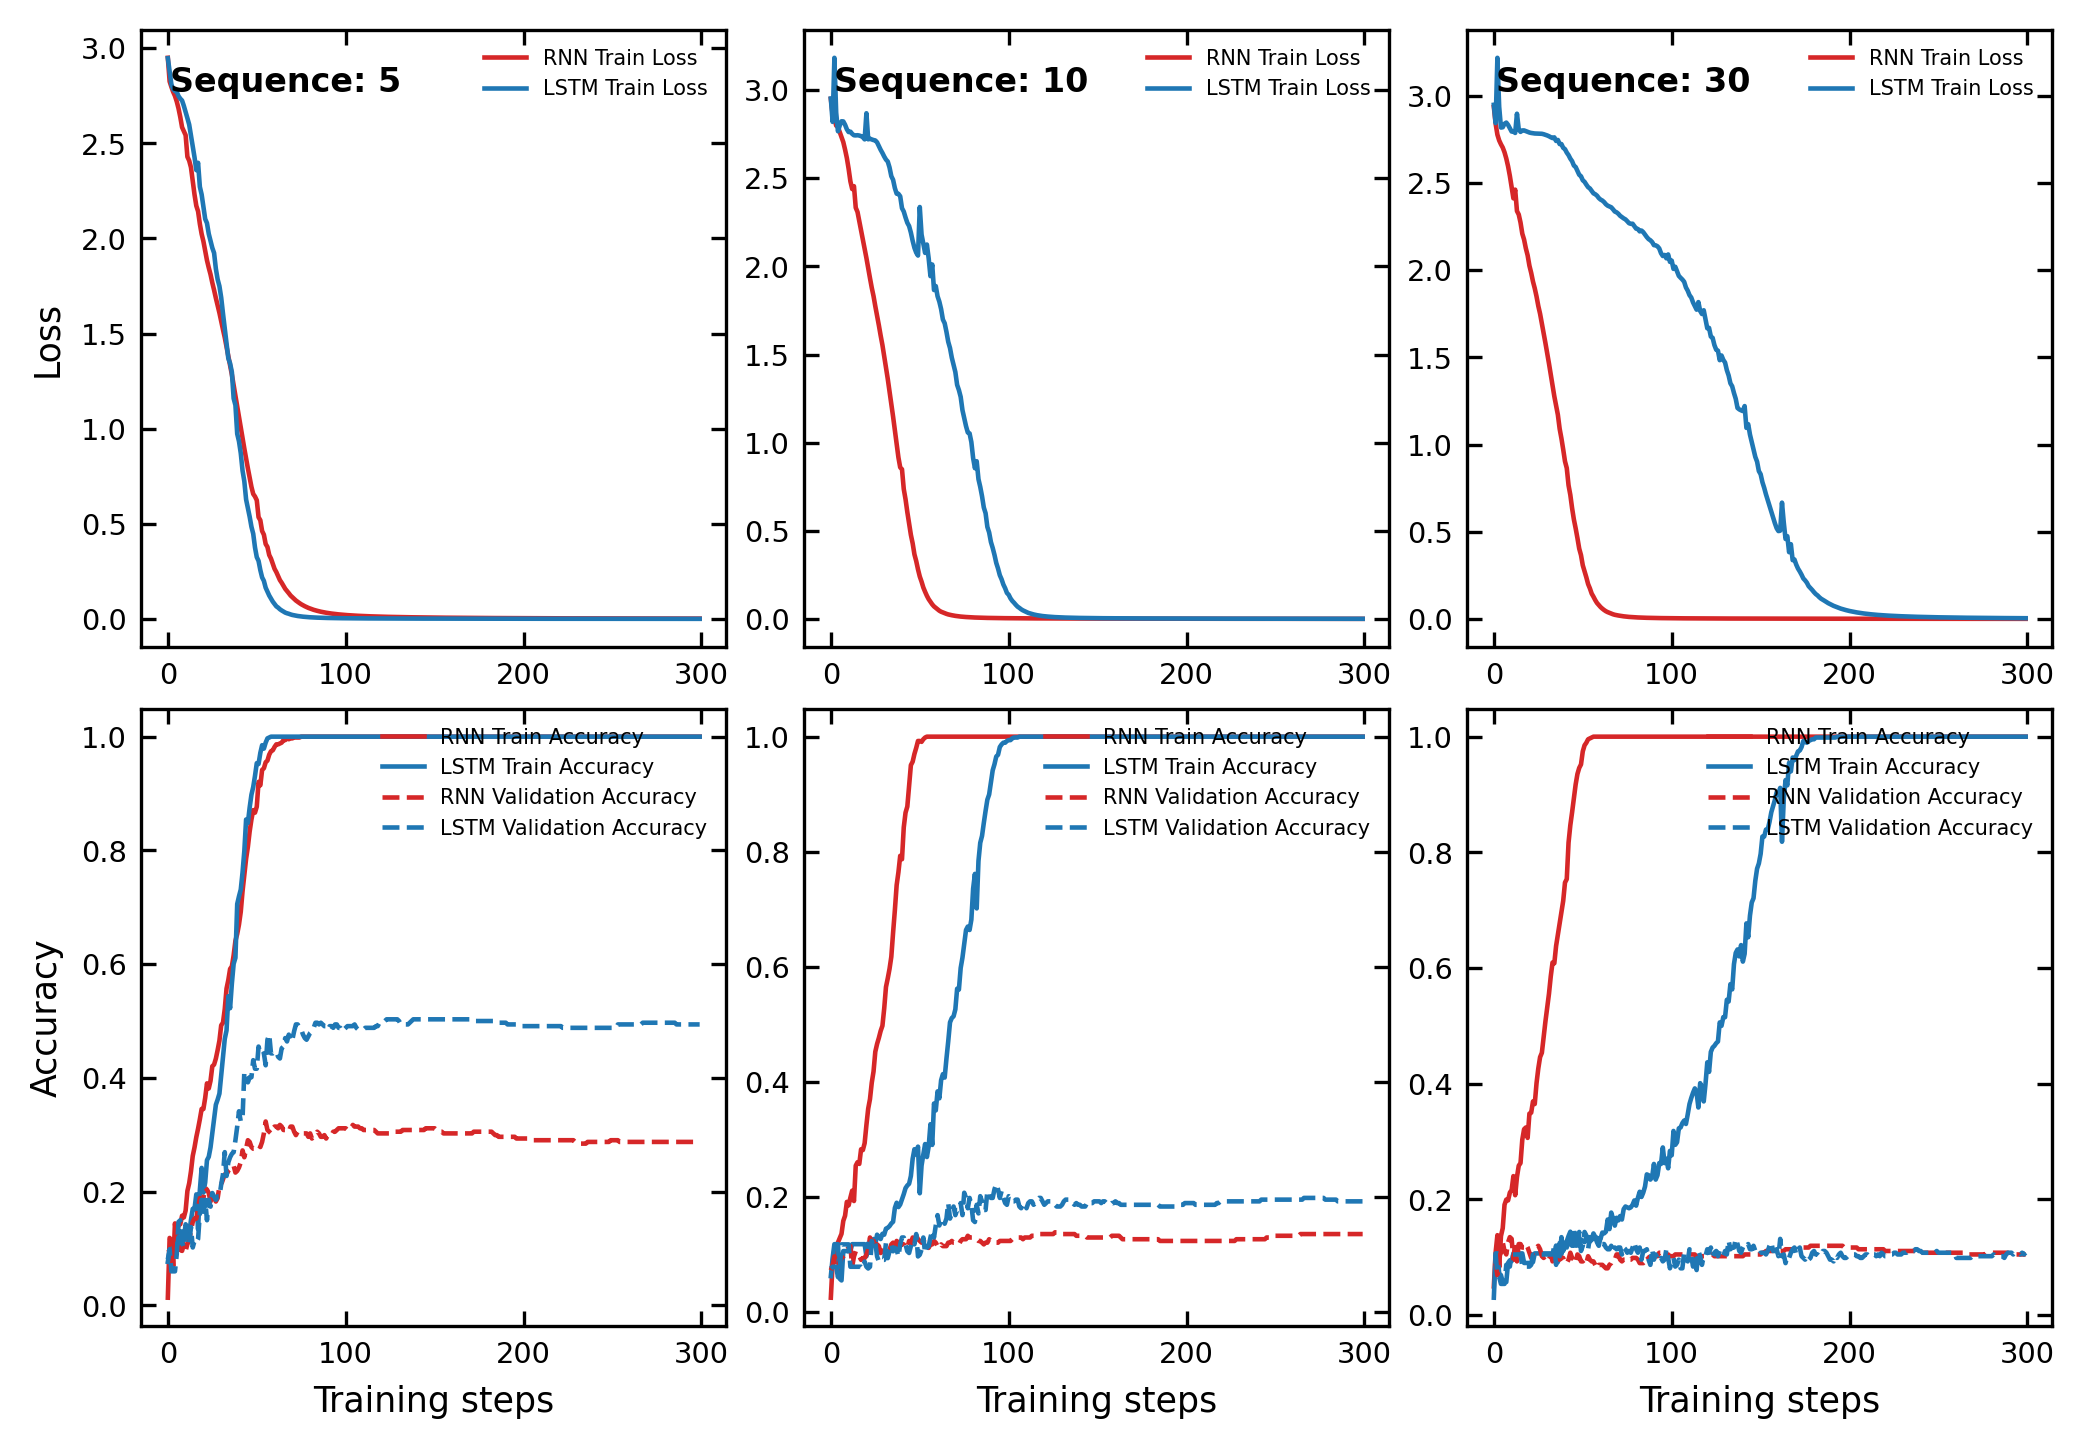

In [ ]:
### Your experiment code goes here
### ==============================
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline

mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
fig_dpi      = 300
fig_typeface = 'Helvetica'
fig_family   = 'monospace'
fig_style    = 'normal'

def trainTestModel(model, opt, X, y,X_test,y_test, n_epochs, verbose=True):
    epoch_lossL = []
    train_accL = []
    test_accL = []
    start = time.time()
    for epoch in range(n_epochs):
        model.zero_grad()
        epoch_loss = 0
        pred = model(X)
        acc = torch.sum(torch.argmax(pred, dim=1) == y) / y.size(0)
        epoch_loss += criterion(pred, y)
        epoch_loss.backward()
        opt.step()


        epoch_lossL.append((epoch_loss.detach()).cpu())
        train_accL.append((acc.detach()).cpu())

        with torch.no_grad():
          pred_test = model(X_test)
          acc_test = torch.sum(torch.argmax(pred_test, dim=1) == y_test) / y_test.size(0)
          test_accL.append((acc_test.detach()).cpu())

        if verbose:
            if epoch == 0 or (epoch + 1) % max(1, n_epochs // 20) == 0:
                minutes = (time.time() - start) / 60
                
                log = "  ".join([
                    f"Epoch: {epoch + 1:3d}",
                    f"in {minutes:4.1f} min",
                    f"Loss: {epoch_loss:10.1f}",
                    f"Train_acc: {acc:.4f}",
                    f"Test_acc: {acc_test:.4f}"
                ])
                print(log)

        # if epoch_loss < 1:
        #     print(f"Done after {epoch} epochs")
        #     break
    return epoch_lossL, train_accL, test_accL



# RNN
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
numExamples = 1000
train_size = int(2/3 * numExamples)
test_size = numExamples - train_size

lr_rnn = 0.005
lr_lstm = 0.013

seqs = [5, 10, 30]
RNN_results = {}
LSTM_results = {}
for seq in seqs:
  model = MyRNN(
    input_size=11,
    hidden_size= 128,
    output_size=19, # allow outputs in range [0, 18]
    num_layers=2,  
    use_LSTM=False).to(device)
  criterion = torch.nn.CrossEntropyLoss().to(device)
  opt = torch.optim.Adam(model.parameters(), lr=lr_rnn)


  print("The sequence length is %d"%seq)
  dataset = Add2DigitsDataset(num_examples= numExamples,seq_length=seq)
  dataTrain, one_hot_dataTrain, labelsTrain = dataset[:train_size]
  dataTest, one_hot_dataTest, labelsTest = dataset[-test_size:]
  one_hot_dataTrain = one_hot_dataTrain.to(device)
  one_hot_dataTest = one_hot_dataTest.to(device)
  labelsTrain = labelsTrain.to(device)
  labelsTest = labelsTest.to(device)
  TrainLoss, TrainAcc, TestAcc = trainTestModel(model, opt, one_hot_dataTrain, labelsTrain, one_hot_dataTest, labelsTest, 300) 
  RNN_results["%d seqTrL"%seq] =  TrainLoss
  RNN_results["%d seqTrA"%seq] =  TrainAcc
  RNN_results["%d seqTeA"%seq] =  TestAcc


for seq in seqs:
  model = MyRNN(
    input_size=11,
    hidden_size= 128,
    output_size=19, # allow outputs in range [0, 18]
    num_layers=2,  
    use_LSTM=True).to(device)
  criterion = torch.nn.CrossEntropyLoss().to(device)
  opt = torch.optim.Adam(model.parameters(), lr=lr_lstm)


  print("The sequence length is %d"%seq)
  dataset = Add2DigitsDataset(num_examples= numExamples,seq_length=seq)
  dataTrain, one_hot_dataTrain, labelsTrain = dataset[:train_size]
  dataTest, one_hot_dataTest, labelsTest = dataset[-test_size:]
  one_hot_dataTrain = one_hot_dataTrain.to(device)
  one_hot_dataTest = one_hot_dataTest.to(device)
  labelsTrain = labelsTrain.to(device)
  labelsTest = labelsTest.to(device)
  TrainLoss, TrainAcc, TestAcc = trainTestModel(model, opt, one_hot_dataTrain, labelsTrain, one_hot_dataTest, labelsTest, 300) 
  LSTM_results["%d seqTrL"%seq] =  TrainLoss
  LSTM_results["%d seqTrA"%seq] =  TrainAcc
  LSTM_results["%d seqTeA"%seq] =  TestAcc

f,ax = plt.subplots(figsize=(6.5, 4.8), dpi=300)
gs1 = gridspec.GridSpec(2, 1)
gs1.update(left=0.01, right=0.31, bottom=0.05, top=0.95, hspace=0.1, wspace=0.)
ax1 = plt.subplot(gs1[0])
ax4 = plt.subplot(gs1[1])
gs2 = gridspec.GridSpec(2, 1)
gs2.update(left=0.35, right=0.65, bottom=0.05, top=0.95, hspace=0.1, wspace=0.)
ax2 = plt.subplot(gs2[0])
ax5= plt.subplot(gs2[1])
gs3 = gridspec.GridSpec(2, 1)
gs3.update(left=0.69, right=0.99, bottom=0.05, top=0.95, hspace=0.1, wspace=0.)
ax3 = plt.subplot(gs3[0])
ax6 = plt.subplot(gs3[1])

for i in range(3):
  exec("ax_a = ax%d"%(i+1))
  exec("ax_b = ax%d"%(i+4))
  seq = seqs[i]
  RNNL = RNN_results["%d seqTrL"%seq]
  LSTML = LSTM_results["%d seqTrL"%seq]
  RNNTrA = RNN_results["%d seqTrA"%seq]
  RNNTeA = RNN_results["%d seqTeA"%seq]
  LSTMTrA = LSTM_results["%d seqTrA"%seq]
  LSTMTeA = LSTM_results["%d seqTeA"%seq]

  TrainSteps = np.arange(300)
  ax_a.plot(TrainSteps, RNNL, color = "tab:red",ls ="-", linewidth=1.1, label='RNN Train Loss')
  ax_a.plot(TrainSteps, LSTML, color = "tab:blue",ls ="-", linewidth=1.1, label='LSTM Train Loss')
  ax_b.plot(TrainSteps, RNNTrA, color = "tab:red",ls ="-", linewidth=1.1, label='RNN Train Accuracy')
  ax_b.plot(TrainSteps, LSTMTrA, color = "tab:blue",ls ="-", linewidth=1.1, label='LSTM Train Accuracy')
  ax_b.plot(TrainSteps, RNNTeA, color = "tab:red",ls ="--", linewidth=1.1, label='RNN Validation Accuracy')
  ax_b.plot(TrainSteps, LSTMTeA, color = "tab:blue",ls ="--", linewidth=1.1, label='LSTM Validation Accuracy')

  ax_a.text(0.05, 0.9, "Sequence: %d"%(seq), size=8, weight = 'bold',style=fig_style, family=fig_family, fontname=fig_typeface, transform=ax_a.transAxes)
  ax_a.legend(loc = 1 ,fontsize = 5,markerscale = 1,ncol = 1,scatterpoints= 1,frameon = True,framealpha =0.).get_frame().set_linewidth(0.0)
  ax_b.legend(loc = 1 ,fontsize = 5,markerscale = 1,ncol = 1,scatterpoints= 1,frameon = True,framealpha =0.).get_frame().set_linewidth(0.0)
  ax_b.set_xlabel('Training steps', size='small')

  ax_a.tick_params(axis='both', which='both',labelleft = True, labelsize='x-small', right=True, top=True, direction='in')
  ax_b.tick_params(axis='both', which='both',labelleft = True, labelsize='x-small', right=True, top=True, direction='in')

ax1.set_ylabel('Loss', size='small')
ax4.set_ylabel('Accuracy', size='small')

# f.savefig("./Question1.png", bbox_inches = "tight")


### __1.3__ Analysis (2 point)

Provide your analysis of the above experiment from Question 1.2. Make sure to mention:
- Was the hypothesis from question 1.1 supported by your data? Why or why not?
- What might be the limitations of your experiment? How would you improve it?

<center>
<strong>It support my hypothesis. As clearly shown in the test accuracy for sequense 5 and 10, LSTM have much better test accuracy than rnn.</strong>
</center>
<center>
<strong>I think the data set is very easy to memorize for both models, which is probabaly why both model overfit greatly. Generate way more data(increase the size of training set) to prevent our model memorizing everything during the training.</strong>
</center>



----
## <a name="2">Question 2: Sequence-to-Sequence Translation (10 points total)</a>

Sequence-to-sequence tasks such as language translation require a model capable of converting variable-length inputs to variable-length outputs, with no guarantee that each position in the input will map directly to a position in the output. This can be thought of as a "many-to-many" task, as illustrated by the second figure from the right in Andrej Karpathy's diagram:

<br/>
<center>
<img width="600px" src="https://raw.githubusercontent.com/zachwooddoughty/cs449w23/main/static/diags.jpeg"/>
</center>
<br/>

<p>
<center>
Image source: "The Unreasonable Effectiveness of Recurrent Neural Networks" (Karpathy)
</center>
</p>

For example, consider the following English-to-Spanish translation:

`I like chocolate` --> `Me gusta el chocolate`

The input sequence contains three words, while the output sequence contains four. Moreover, the individual words and grammatical structure of the sentences do not cleanly correspond, as `chocolate` is preceded by the definite article `el` and the subject switches from the speaker to the chocolate. It's easy to see why sequence-to-sequence translation can be a challenging task!

To overcome these difficulties, [Sutskever et al.](https://arxiv.org/pdf/1409.3215.pdf) proposed to use recurrent __encoder__ and __decoder__ networks. First, special __start and stop tokens__ are added to the ends of all sentences. Then, the encoder RNN loops over an input sequence, and its final hidden state is taken as a representation of the entire input "context." This context is passed to the decoder RNN, which generates one word at a time __autoregressively__ (taking its own past predictions as inputs) until it produces a stop token. This allows for arbitrary input and output lengths, as (a) the only representation of the input that the decoder sees is a single context vector, and (b) the decoder is free to generate for as long as it wants to before emitting a stop token.

<br/>
<center>
<img width="600px" src="https://raw.githubusercontent.com/zachwooddoughty/cs449w23/main/static/sutskever.png"/>
</center>
<br/>

<p>
<center>
Image source: "Sequence to Sequence Learning with Neural Networks" (Sutskever et al. 2014). "EOS" is the end-of-sentence stop token.
</center>
</p>

In this question, we'll explore how to use the encoder-decoder architecture to perform Turkish-to-English translation. This will require a bit of setup, which is documented in the next section. To simplify the process and avoid messing with your local Python environment, it's recommended that you use [Google Colab](https://colab.research.google.com/).

As a final note, a version of this question was adapted from Ben Trevett's [tutorials on sequence modeling in PyTorch](https://github.com/bentrevett/pytorch-seq2seq). You are welcome to look at these and other tutorials for additional information, but you should not copy code from them unless you first ask for explicit permission.

In [ ]:
# Download 1000 training examples and 100 test examples
# for a Turkish <-> English translation dataset

train_dataset = load_dataset("wmt16", "tr-en", split="train[:1000]")
test_dataset = load_dataset("wmt16", "tr-en", split="test[:100]")

tr_tokenizer = AutoTokenizer.from_pretrained("dbmdz/bert-base-turkish-cased")
print(f"Turkish vocab size: {tr_tokenizer.vocab_size}")
en_tokenizer = BertTokenizer.from_pretrained("bert-base-cased")
print(f"English vocab size: {en_tokenizer.vocab_size}")

Turkish vocab size: 32000
English vocab size: 28996


In [ ]:
# Show an example and the tokenization of the text

example = next(iter(train_dataset))["translation"]
print("# Turkish")
print(example["tr"])
print(tr_tokenizer(example["tr"])["input_ids"])
print(tr_tokenizer.decode(tr_tokenizer(example["tr"])["input_ids"]))

print("\n# English")
print(example["en"])
print(en_tokenizer(example["en"])["input_ids"])
print(en_tokenizer.decode(en_tokenizer(example["en"])["input_ids"]))

# Turkish
Kosova'nın özelleştirme süreci büyüteç altında
[2, 9868, 11, 2732, 20539, 6607, 9734, 2100, 3282, 3]
[CLS] Kosova'nın özelleştirme süreci büyüteç altında [SEP]

# English
Kosovo's privatisation process is under scrutiny
[101, 11494, 112, 188, 185, 2047, 26465, 5771, 1965, 1110, 1223, 19258, 102]
[CLS] Kosovo's privatisation process is under scrutiny [SEP]


In [ ]:
# Preprocess and batch our datasets
# Here, we are fixing sequences to be no longer than 10 tokens,
#   which is a substantial limitation. However, it makes things faster.
MAX_LENGTH = 10

from torch.utils.data import DataLoader, Subset

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def tokenize(example):
    pair = example["translation"]
    tr_tokens = tr_tokenizer(pair["tr"])["input_ids"][:MAX_LENGTH]
    en_tokens = en_tokenizer(pair["en"])["input_ids"][:MAX_LENGTH]
    retval = {"tr_tokens": tr_tokens, "en_tokens": en_tokens}

    return retval

def collate(batch):
    tr_tokens = [torch.Tensor(x["tr_tokens"]).long().to(device) for x in batch]
    tr_batch = torch.nn.utils.rnn.pad_sequence(tr_tokens, batch_first=True,)

    en_tokens = [torch.Tensor(x["en_tokens"]).long().to(device) for x in batch]
    en_batch = torch.nn.utils.rnn.pad_sequence(en_tokens, batch_first=True)

    return (tr_batch, en_batch)

tokenized_train = train_dataset.map(tokenize)
batched_train = DataLoader(tokenized_train, batch_size=64,
                           drop_last=False, collate_fn=collate)
tokenized_test = test_dataset.map(tokenize)
batched_test = DataLoader(tokenized_test, batch_size=64,
                           drop_last=False, collate_fn=collate)

In [ ]:
# Print out some (padded, batched) examples
for example in batched_train:
    src, trg = example
    print(src[:5, :])
    print(trg[:5, :])
    break

tensor([[    2,  9868,    11,  2732, 20539,  6607,  9734,  2100,  3282,     3],
        [    2,  9868,    16,  3404,  2720,  6329,  1990, 15000, 20539, 12799],
        [    2, 24955, 20169, 12153,  2058,  6903, 26802,  2049,    11,  2350],
        [    2,  6654,  4655,  1983,  4239,  2180,  2478, 12885,  7627,  1992],
        [    2,  2654,  6847,  7845,  2961,    16,  5412,  1996,  4895,  2200]])
tensor([[  101, 11494,   112,   188,   185,  2047, 26465,  5771,  1965,  1110],
        [  101, 11494,  1110,  1781,   170,  1662,  1440,  1120,  1157,   185],
        [  101,  1650, 19569, 25948,  1204,   139, 18663,  2737,  9012,  1111],
        [  101, 11907,  3484, 13012,  1233,  1108,   185,  2047, 26465,  3673],
        [  101,  1212,  2526,  1120,  1655,   117,  1122,  2736,  1176,   170]])


# __2.1__ RNN Translation (3 points)

Finally, we can train an encoder-decoder model to perform sequence-to-sequence translation.

__Modify the definitions in the cell below as instructed by the accompanying comments. Then, run the following cell to train and evaluate your encoder-decoder network for Turkish-to-English translation. Finally, include a plot of your training and validation losses by epoch where instructed below.__


If your implementation is "correct," you should see your loss decrease as your model trains. You can also check your implementation by running the example translation provided after the training code.

When you're trying to get your code to run, don't worry about whether the model outputs "the" over and over again or has other silly behaviors. __It may take ~500 epochs for the model to fully learn the training data!__

In [ ]:
class RNNEncoder(torch.nn.Module):

    def __init__(self, 
                 input_size: int, 
                 embedding_size: int, 
                 hidden_size: int, 
                 depth: int):
      
        super().__init__()
                
        self.hidden_size = hidden_size
        self.depth = depth
        
        # embedding layer: similar to one-hot encoding, we will map
        # integer indices to vectors
        self.embedding = torch.nn.Embedding(input_size, embedding_size)
        
        ###########################################################
        # YOUR CODE STARTS HERE (1/5)
        ###########################################################
        self.rnn = nn.RNN(
            input_size=embedding_size,
            hidden_size=hidden_size,
            num_layers=depth,
            batch_first=True)
        #self.out_proj = nn.Linear(embedding_size, hidden_size)
        ###########################################################
        # YOUR CODE ENDS HERE (1/5)
        ###########################################################
        
        # a dropout layer can improve generalization
        self.dropout = torch.nn.Dropout(0.5)
        
    def forward(self, x: torch.Tensor):
        
        assert x.ndim == 2
        batch_size, seq_len = x.shape

        # convert integer indices to vector representations
        embedded = self.dropout(self.embedding(x))  # (batch_size, seq_len, embedding_size)

        ###########################################################
        # YOUR CODE STARTS HERE (2/5)
        ###########################################################
        output, hidden = self.rnn(embedded)
        #print(hidden,hidden.shape)
        #print(output,output.shape)
        #output = output[:,-1,:]
        #output = torch.reshape(output, [1,output.shape[0],output.shape[1]])
        #print('encoder output: hidden = ', output, output.shape)       
        return hidden
        ###########################################################
        # YOUR CODE ENDS HERE (2/5)
        ###########################################################

class RNNDecoder(torch.nn.Module):

    def __init__(self, 
                 output_size: int, 
                 embedding_size: int, 
                 hidden_size: int, 
                 depth: int):
      
        super().__init__()

        self.hidden_size = hidden_size
        self.depth = depth
        self.output_size = output_size
        
        # embedding layer: similar to one-hot encoding, we will map
        # integer indices to vectors
        self.embedding = torch.nn.Embedding(output_size, embedding_size)

        ###########################################################
        # YOUR CODE STARTS HERE (3/5)
        ###########################################################
        self.rnn = nn.RNN(
            input_size=embedding_size,
            hidden_size=hidden_size,
            num_layers=depth,
            batch_first=True)
        self.out_proj = nn.Linear(hidden_size, output_size)
        ###########################################################
        # YOUR CODE ENDS HERE (3/5)
        ###########################################################
        
        # a dropout layer can improve generalization
        self.dropout = torch.nn.Dropout(0.5)
        
    def forward(self, x: torch.Tensor, hidden: torch.Tensor):
        
        # take a single time-step of input and a single hidden state
        if x.ndim == 1:
            x = x.unsqueeze(1)
        batch_size, _ = x.shape
        
        # convert integer indices to vector representations
        embedded = self.dropout(self.embedding(x))  # (batch_size, seq, embedding_size)

        ###########################################################
        # YOUR CODE STARTS HERE (4/5)
        ###########################################################
        #weight = np.exp(hidden)/np.sum(np.exp(hidden))
        output, hidden = self.rnn(embedded, hidden)
        output = output[:,-1,:]        
        output = self.out_proj(output)
        return output, hidden
        ###########################################################
        # YOUR CODE ENDS HERE (4/5)
        ###########################################################


class RNNTranslator(torch.nn.Module):
    def __init__(self, 
                 encoder: torch.nn.Module, 
                 decoder: torch.nn.Module, 
                 device):
      
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        
        assert encoder.hidden_size == decoder.hidden_size, \
        f"Mismatch: `encoder.hidden_size` = {encoder.hidden_size}, `decoder.hidden_size` = {decoder.hidden_size}"
        
        assert encoder.depth == decoder.depth, \
        f"Mismatch: `encoder.depth` = {encoder.depth}, `decoder.depth` = {decoder.depth}"
        
    def forward(self, x: torch.Tensor, y: torch.Tensor, teacher_forcing_ratio: float = 0.5):
 
        # inputs should have shape (batch_size, in_seq_len)
        assert x.ndim == 2
        batch_size, in_seq_len = x.shape

        # targets should have shape (batch size, out_seq_len,)
        assert y.ndim == 2
        _, out_seq_len = y.shape
        out_vocab_size = self.decoder.output_size
        
        # prepare to store decoder outputs. We only need to allocate 
        # the "true" number of time steps during training, but for inference
        # we can simply pass in an empty `y` of any length; this will serve as
        # a maximum length constraint on the output translation (which may end
        # sooner if an <EOS> token is predicted).
        outputs = []
        
        ###########################################################
        # YOUR CODE STARTS HERE (5/5)
        ###########################################################
        hidden = self.encoder(x)
        ###########################################################
        # YOUR CODE ENDS HERE (5/5)
        ###########################################################

        # first input to the decoder is the <SOS> start token
        input = y[:,:1]

        for t in range(1, out_seq_len):

            # given input for current time step (either previous decoder 
            # prediction or <SOS> token) and previous hidden state, compute
            # new output and hidden states
            output, hidden = self.decoder(input, hidden)

            # write predicted word probabilities to output buffer
            outputs.append(output)
            
            # during training, we may randomly decide whether to use
            # the decoder's previous predictions or the ground-truth
            # tokens for the previous time step. When we do the latter,
            # it is called "teacher-forcing." We will randomly apply 
            # teacher-forcing during training only.
            teacher_force = random.random() < teacher_forcing_ratio
            
            # take highest-scoring token from decoder's previous prediction
            top1 = output.argmax(1).unsqueeze(1)
            
            # optionally apply teacher-forcing
            input = y[:, t] if teacher_force else top1
        
        outputs = torch.stack(outputs, axis=1).to(self.device)
        return outputs

# 2.2 LSTM Translation (2 points)

The following code (almost) implements an LSTM variation on the RNN translator you implemented above.
Until you have your RNNTranslator class running with the experimental code below, you should skip this cell. 

In [ ]:
class LSTMEncoder(torch.nn.Module):

    def __init__(self,
                 input_size: int, 
                 embedding_size: int, 
                 hidden_size: int, 
                 depth: int):
      
        super().__init__()
                
        self.hidden_size = hidden_size
        self.depth = depth
        
        # embedding layer: similar to one-hot encoding, we will map
        # integer indices to vectors
        self.embedding = torch.nn.Embedding(input_size, embedding_size)
        
        ###########################################################
        # YOUR CODE STARTS HERE (1/5)
        ###########################################################
        self.lstm = nn.LSTM(
            input_size=embedding_size,
            hidden_size=hidden_size,
            num_layers=depth,
            batch_first=True)        
        ###########################################################
        # YOUR CODE ENDS HERE (1/5)
        ###########################################################
        
        # a dropout layer can improve generalization
        self.dropout = torch.nn.Dropout(0.8)
        
    def forward(self, x: torch.Tensor):

        assert x.ndim == 2
        batch_size, seq_len = x.shape

        # convert integer indices to vector representations
        embedded = self.dropout(self.embedding(x))  # (batch_size, seq_len, embedding_size)
        
         ###########################################################
        # YOUR CODE STARTS HERE (2/5)
        ###########################################################
        output, (hidden, cell) = self.lstm(embedded)
        #print(output,output.shape)
        #print(cell,cell.shape)
        #print(hidden,hidden.shape)        
        return hidden, cell
        ###########################################################
        # YOUR CODE ENDS HERE (2/5)
        ###########################################################



class LSTMDecoder(torch.nn.Module):

    def __init__(self, 
                 output_size: int, 
                 embedding_size: int, 
                 hidden_size: int, 
                 depth: int):
      
        super().__init__()

        self.hidden_size = hidden_size
        self.depth = depth
        self.output_size = output_size
        
        # embedding layer: similar to one-hot encoding, we will map
        # integer indices to vectors
        self.embedding = torch.nn.Embedding(output_size, embedding_size)

        ###########################################################
        # YOUR CODE STARTS HERE (3/5)
        ###########################################################
        self.lstm = nn.LSTM(
            input_size=embedding_size,
            hidden_size=hidden_size,
            num_layers=depth,
            batch_first=True)        
        self.out_proj = nn.Linear(hidden_size, output_size)
        ###########################################################
        # YOUR CODE ENDS HERE (3/5)
        ###########################################################
        
        # a dropout layer can improve generalization
        self.dropout = torch.nn.Dropout(0.8)
        
    def forward(self, x: torch.Tensor, hidden: torch.Tensor, cell: torch.Tensor):

        # take a single time-step of input, a single hidden state, and a single cell state
        if x.ndim == 1:
            x = x.unsqueeze(1)
        batch_size, _ = x.shape
        
        # convert integer indices to vector representations
        embedded = self.dropout(self.embedding(x))  # (batch_size, 1, embedding_size)

        ###########################################################
        # YOUR CODE STARTS HERE (4/5)
        ###########################################################
        output, (hidden, cell) = self.lstm(embedded)
        output = output[:,-1,:]
        output = self.out_proj(output)
        return output, hidden, cell
        ###########################################################
        # YOUR CODE ENDS HERE (4/5)
        ###########################################################


class LSTMTranslator(nn.Module):

    def __init__(self, 
                 encoder: torch.nn.Module,
                 decoder: torch.nn.Module,
                 device: str):
      
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        
        assert encoder.hidden_size == decoder.hidden_size, \
        f"Mismatch: `encoder.hidden_size` = {encoder.hidden_size}, `decoder.hidden_size` = {decoder.hidden_size}"
        
        assert encoder.depth == decoder.depth, \
        f"Mismatch: `encoder.depth` = {encoder.depth}, `decoder.depth` = {decoder.depth}"
        
    def forward(self, x: torch.Tensor, y: torch.Tensor, teacher_forcing_ratio: float = 0.5):
        
        # inputs should have shape (batch_size, in_seq_len)
        assert x.ndim == 2
        batch_size, in_seq_len = x.shape

        # targets should have shape (batch size, out_seq_len,)
        assert y.ndim == 2
        _, out_seq_len = y.shape
        out_vocab_size = self.decoder.output_size
        
        # prepare to store decoder outputs. We only need to allocate 
        # the "true" number of time steps during training, but for inference
        # we can simply pass in an empty `y` of any length; this will serve as
        # a maximum length constraint on the output translation (which may end
        # sooner if an <EOS> token is predicted).
        outputs = []
        
        ###########################################################
        # YOUR CODE STARTS HERE (5/5)
        ###########################################################
        hidden, cell = self.encoder(x)
        ###########################################################
        # YOUR CODE ENDS HERE (5/5)
        ###########################################################

        # first input to the decoder is the <SOS> start token
        input = y[:,:1]

        for t in range(1, out_seq_len):

            # given input for current time step (either previous decoder 
            # prediction or <SOS> token) and previous hidden state and
            # cell state, compute new output, hidden, and cell states
            output, hidden, cell = self.decoder(input, hidden, cell)

            # save predicted word probabilities
            outputs.append(output)
            
            # during training, we may randomly decide whether to use
            # the decoder's previous predictions or the ground-truth
            # tokens for the previous time step. When we do the latter,
            # it is called "teacher-forcing." We will randomly apply 
            # teacher-forcing during training only.
            teacher_force = random.random() < teacher_forcing_ratio
            
            # take highest-scoring token from decoder's previous prediction
            top1 = output.argmax(1).unsqueeze(1)
            
            # optionally apply teacher-forcing
            input = y[:, t] if teacher_force else top1
        
        outputs = torch.stack(outputs, axis=1).to(self.device)
        return outputs

# 2.3 Translation experiments (5 points)

For either the RNN or the LSTM, you will use the same experimental code below. The hyperparameter values we've given you are ones that worked for us, but you are welcome to change them. You shouldn't need to change any training code below the line that says "Don't change code below this line."

As you run experiments, keep track of what hyperparameters you're using and how the model trains. Are you able to learn anything? Does your model overfit? You'll answer these below.

The model has 20,014,916 trainable parameters
Kosovo's privatisation process is
Communications Communications Communications Communications Communications Communications dialects Communications Communications
Epoch: 01 | Time: 0m 16s
	Train Loss: 8.682
	 Val. Loss: 8.109
Kosovo's privatisation process is
,,,,,,,,,
Epoch: 02 | Time: 0m 17s
	Train Loss: 6.897
	 Val. Loss: 8.160
Kosovo's privatisation process is
The,,,,,, the,
Epoch: 03 | Time: 0m 17s
	Train Loss: 6.654
	 Val. Loss: 8.417
Kosovo's privatisation process is
The the the the the the the the the
Epoch: 04 | Time: 0m 16s
	Train Loss: 6.557
	 Val. Loss: 8.564
Kosovo's privatisation process is
The, s,,,,, the
Epoch: 05 | Time: 0m 17s
	Train Loss: 6.466
	 Val. Loss: 8.415


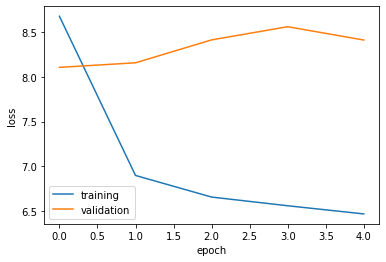

In [ ]:
# Training hyperparameters; you are welcome to change these.
# In my experiments, it can take ~500 epochs over the dataset
#   of 1000 training examples before it perfectly
#   translates the training examples.

ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
HID_DIM = 128
N_LAYERS = 2
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5
N_EPOCHS = 5
CLIP = 1
LR = 0.03
USE_LSTM = True

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

###  Don't change code below this line
###  =================================

INPUT_DIM = tr_tokenizer.vocab_size
OUTPUT_DIM = en_tokenizer.vocab_size
TRG_PAD_IDX = 0

# initialize encoder-decoder model
if USE_LSTM:
    enc = LSTMEncoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS).to(device)
    dec = LSTMDecoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS).to(device)
    model = LSTMTranslator(enc, dec, device)
else:
    enc = RNNEncoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS).to(device)
    dec = RNNDecoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS).to(device)
    model = RNNTranslator(enc, dec, device)

# initialize model weights
def init_weights(m):
    for name, param in m.named_parameters():
        torch.nn.init.uniform_(param.data, -0.08, 0.08)
model.apply(init_weights)

# parameter count
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'The model has {count_parameters(model):,} trainable parameters')

# optimizer and loss function
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
criterion = torch.nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)

# track training and validation losses
training_loss = []
validation_loss = []

def train(model, iterator, optimizer, criterion, clip, verbose=False):
    
    model.train()
    epoch_loss = 0
    
    for i, batch in enumerate(iterator):
        
        (src, trg) = batch
        
        optimizer.zero_grad()
        output = model(src, trg)

        # Every so often, print out how well we're doing.
        if verbose and i == 0:
            print(en_tokenizer.decode(trg[0, 1:]))
            en_tokens = output[0, :, :].argmax(1)
            print(en_tokenizer.decode(en_tokens))

        output_dim = output.shape[-1]
        output = output.reshape(-1, output_dim)
        trg = trg[:, 1:].reshape(-1)

        loss = criterion(output, trg)
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        
        epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

def evaluate(model, iterator, criterion):
    
    model.eval()
    epoch_loss = 0
    
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):

            (src, trg) = batch 

            output = model(src, trg, 0) #turn off teacher forcing
            output_dim = output.shape[-1]
            
            output = output.reshape(-1, output_dim)
            trg = trg[:, 1:].reshape(-1)

            loss = criterion(output, trg)
            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs
    
start_time = time.time()
for epoch in range(N_EPOCHS):

    verbose = (epoch == 0 or N_EPOCHS <= 10
               or (epoch + 1) % (N_EPOCHS // 10) == 0)

    train_loss = train(model, batched_train, optimizer,
                       criterion, CLIP, verbose=verbose)
    valid_loss = evaluate(model, batched_test, criterion)
    
    training_loss.append(train_loss)
    validation_loss.append(valid_loss)
    
    # Every so often, print some details on how we're doing.
    if verbose:
        end_time = time.time()
        epoch_mins, epoch_secs = epoch_time(start_time, end_time)
        print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
        print(f'\tTrain Loss: {train_loss:.3f}')
        print(f'\t Val. Loss: {valid_loss:.3f}')    
        start_time = time.time()

# At the end, enerate loss plot
import matplotlib.pyplot as plt
plt.plot(training_loss, label="training")
plt.plot(validation_loss, label="validation")
plt.legend()
plt.xlabel("epoch")
plt.ylabel("loss")
plt.show()

If you want to explore how sensitive the model is to small changes in the input, you can translate things into Turkish using Google Translate and then see how they are affected here.

In [ ]:
sentence = "Kosova'nın özelleştirme süreci büyüteç altında"

tokens = tr_tokenizer(sentence)["input_ids"]
tokens = torch.tensor([tokens]).long().to(device)
print(tokens)
dummy_output = torch.ones([1, MAX_LENGTH]).long().to(device)

with torch.no_grad():
    output = model(tokens, dummy_output, 0).cpu()
    en_tokens = output[0, :, :].argmax(1)
    print(en_tokenizer.decode(en_tokens))

tensor([[    2,  9868,    11,  2732, 20539,  6607,  9734,  2100,  3282,     3]])
the, the, the, the, the


## 2.3.1 Experimental Results (5 points)

Write at least five sentences about what you noticed during your experiments. Include at least two plots of successful training curves over time. Make sure to mention:

- What hyperparameters had the most effect on your model's ability to reduce the *training* loss?
- What about for the *validation* loss?
- What was necessary to prevent underfitting?
- What were you able to do to prevent overfitting?

<center><strong>The model is clearly over fitting.</strong></center>
<center><strong>As I tried, learning rate and epoch times both help reducing the training loss.</strong></center>
<center><strong>Increasing the drop out rate helped in reducing the validation loss.</strong></center>
<center><strong>I believe enough training epochs and proper learning rate can help prevent underfitting. Also enough layers and enough hidden size helps too.(The bigger of this two the more unlikely a model will underfit)</strong></center>
<center><strong>I tried to decrease the layers of our model to 1, it doesn't work well. I also tried to increasing the drop out rate in LSTMEncoder and LSTMDecoder to 0.8, but it doesn't show clear improvement either.
</strong></center>
<br/>
<center><strong>LSTMTranslator with lr = 0.03 else the same as default:</strong></center>

<figure>
<center>
<img src="https://github.com/cs449w23/hw3-hw3_449/blob/main/2_3_1.png"/>
<figcaption>This is the picture 2_3_1.png in our main branch, the link is fine but it doesn't show picture</figcaption></center>
</figure>
<br/>
</strong></center>
<center><strong>LSTMTranslator with LR = 0.03 N_LAYERS = 1, else the same as default:</strong></center>
<figure>
<center>
<img src="https://github.com/cs449w23/hw3-hw3_449/blob/main/2_3_2.png"/>
<figcaption>This is the picture 2_3_2.png in our main branch, the link is fine but it doesn't show picture</figcaption></center>
</figure>
<br/>
</strong></center>
<center><strong>LSTMTranslator with LR = 0.03, drop out rate in LSTMEncoder and LSTMDecoder set to 0.8, else the same as default:</strong></center>
<figure>
<center>
<img src="https://github.com/cs449w23/hw3-hw3_449/blob/main/2_3_3.png"/>
<figcaption>This is the picture 2_3_3.png in our main branch, the link is fine but it doesn't show picture</figcaption></center>
</figure>

# 3. Conceptual Questions (4 points)

### 3.1 RNN vs Fully-connected (1.5 points)

Suppose we're doing sequence *classification* instead of translation, and because we're going to limit all our sequences to a max length of 10 tokens. 

Suppose we have a vocabulary of 10,000 tokens, we're embedding each word into a 100-dimensional vector, each sentence is exactly 10 tokens long, and we're doing binary classification.

Consider two different networks:

- a MLP with two hidden fully-connected layers with 256 hidden nodes each followed by a final fully-connected layer for binary classification.
- a torch.nn.RNN like the one you used above, with a hidden size of 256, and a final fully-connected layer that outputs a binary classification.

Answer the following three questions:

* (a.) To the nearest thousand parameters, how many parameters do the MLP and RNN each have?
* (b.) Suppose instead that all sequences are exactly 40 tokens long. Now, to the nearest thousand parameters, how many parameters does each model have?
* (c.) What does this say about when you might prefer an RNN or an MLP?

<center><strong>(a)MLP: 322,562; RNN: 223,234</strong></center>
<center><strong>(b)MLP: 1,090,562; RNN: 223,234</strong></center>
<center><strong>I showed my work in the picture below.</strong></center>
<br/>
<figure>
<center>
<img src="https://github.com/cs449w23/hw3-hw3_449/blob/main/3_1.jpeg"/>
<figcaption>This is the picture 3_1.jpeg in our main branch, the link is fine but it doesn't show picture</figcaption></center>
</figure>
<br/>
<center><strong>(c)I will pefer RNN when the sequence is long for the number of parameters for RNN is much less than that of MLP</strong></center>

### 3.2 RNNs versus Transformers (1.5 points)

Suppose you wanted to implement a translation model like the one above using Transformers, but wanted to maintain the Encoder and Decoder structure. Answer the following questions:

* (a.) What would be one theoretical advantage of using Transformer models over LSTMs?
* (b.) What would be one theoretical advantage of using LSTMs over Transformers?
* (c.) Consider the input tensors and their shapes that are passed into `self.encoder()` and `self.decoder()` inside of the `LSTMTranslator` class. If your encoder and decoder were both Transformer models, what inputs would they take? Why?

<center><strong>(a)Transformer is more parallelizable.</strong></center>
<center><strong>(b)Lstm deals with time series better. For it takes the input as sequense of time steps. It also deals with long sequense better I guess, for less parameters and it can learn long-term dependency better.</strong></center>
<center><strong>(c)For encoder, input should be like a tensors of shape (batch_size, sequence_length, input_size). For decoder, input should be like a tensors of shape(batch_size, sequence_length, hidden_size). For the decoder just look at the learned(encoded) vector given by encoder.</strong></center>

### 3.3 Teacher forcing (1 point)

In the code we provide, there is a hyperparameter for "teacher-forcing" which you can read more about here: https://en.wikipedia.org/wiki/Teacher_forcing

Then, answer the following questions:

* (a.) Why is it important that we set the probability of teacher forcing to 0% at test time?
* (b.) Under what circumstances might you want to have a higher probability during training time? A lower probability? Why?

<center><strong>(a)At test time, the model should make predictions only based on its own output at each time step instead of the ground-truth tokens for the previous time step. Otherwise, the test accuracy may be high though the model is not robust enough.</strong></center>
<center><strong>(b)Because teacher forcing helps to reduce the training time as written in Wiki page, we want it higher when training time is too long.</strong></center>
<center><strong>I think when the model is overfitting, we should use a lower probability of teacher forcing. For teacher forcing makes the model more dependent on the data it was trained on.</strong></center>